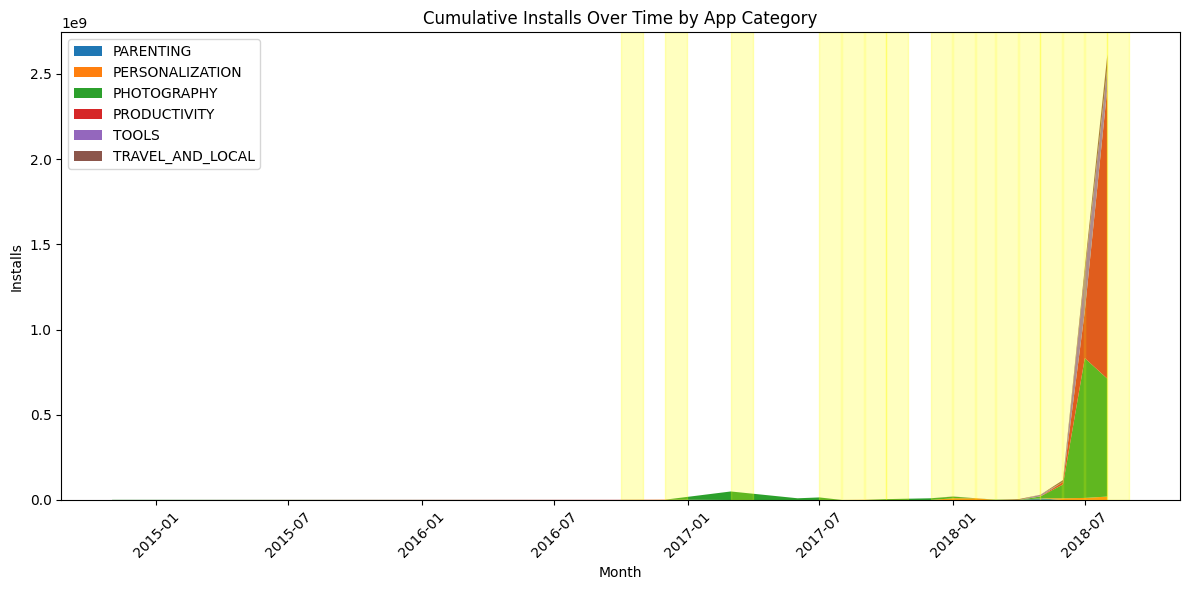

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time
import pytz
import re

# ---------------- LOAD DATA ----------------
df = pd.read_csv('Play Store Data.csv')

# ---------------- CLEAN ----------------
df_clean = df.dropna(subset=['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs']).copy()

df_clean['Reviews'] = pd.to_numeric(df_clean['Reviews'], errors='coerce')
df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')

# ---- Size to MB ----
def size_to_mb(size):
    size = str(size)
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1024
    elif 'G' in size:
        return float(size.replace('G', '')) * 1024
    return np.nan

df_clean['Size_MB'] = df_clean['Size'].apply(size_to_mb)

# ---- Clean installs ----
df_clean['Installs'] = (
    df_clean['Installs']
    .astype(str)
    .str.replace('+','', regex=False)
    .str.replace(',','', regex=False)
)

df_clean['Installs'] = pd.to_numeric(df_clean['Installs'], errors='coerce')

# ---------------- APPLY REQUIRED FILTERS ----------------
df_filtered = df_clean.loc[
    (df_clean['Rating'] >= 4.2) &
    (df_clean['Reviews'] > 1000) &
    (df_clean['Size_MB'].between(20, 80)) &
    (df_clean['Category'].str.startswith(('T','P'), na=False)) &
    (~df_clean['App'].str.contains(r'\d', regex=True))   # no numbers in app name
].copy()

# ---------------- TRANSLATE LEGEND ----------------
translation_map = {
    'Travel & Local': 'Voyage & Local',   # French
    'Productivity': 'Productividad',      # Spanish
    'Photography': '写真'                  # Japanese
}

df_filtered['Category_Translated'] = (
    df_filtered['Category']
    .map(translation_map)
    .fillna(df_filtered['Category'])
)

# ---------------- DATE HANDLING ----------------
df_filtered['Last Updated'] = pd.to_datetime(
    df_filtered['Last Updated'],
    format='%B %d, %Y',
    errors='coerce'
)

df_filtered = df_filtered[df_filtered['Last Updated'].notna()].copy()
df_filtered['Month'] = df_filtered['Last Updated'].dt.to_period('M')

# ---------------- MONTHLY CUMULATIVE DATA ----------------
monthly_installs = (
    df_filtered
    .groupby(['Month','Category_Translated'])['Installs']
    .sum()
    .unstack(fill_value=0)
)

# ---------------- GROWTH HIGHLIGHT ----------------
growth = monthly_installs.pct_change()
highlight_months = growth.gt(0.25).any(axis=1)

# ---------------- TIME WINDOW (4 PM – 6 PM IST) ---------------- 16 18
ist = pytz.timezone('Asia/Kolkata')
now = datetime.now(ist).time()

start_time = time(16, 0)
end_time   = time(18, 0)

# ---------------- PLOT ----------------
if start_time <= now <= end_time and not monthly_installs.empty:

    plot_df = monthly_installs.copy()
    plot_df.index = plot_df.index.to_timestamp()

    fig, ax = plt.subplots(figsize=(12,6))

    ax.stackplot(
        plot_df.index,
        plot_df.T.values,
        labels=plot_df.columns
    )

    # Highlight months where growth > 25%
    for month, flag in zip(plot_df.index, highlight_months):
        if flag:
            ax.axvspan(month, month + pd.offsets.MonthEnd(1), alpha=0.25, color='yellow')

    ax.set_title("Cumulative Installs Over Time by App Category")
    ax.set_xlabel("Month")
    ax.set_ylabel("Installs")
    ax.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("⏰ Chart visible only between 4 PM and 6 PM IST (or no data after filters)")
